## Face recognition model
#### This is the final project for the CSCA 5642 class, introduction to Deep Learning.

##### Dataset Description:

The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image. Each face image belongs to one of the following expression categories:

- 0 = Angry
- 1 = Disgust
- 2 = Fear
- 3 = Happy
- 4 = Sad
- 5 = Surprise
- 6 = Neutral

##### Manas Sambare. (2013). Face expressions recognition . Kaggle. https://www.kaggle.com/datasets/msambare/fer2013/data

##### Problem Description:

- The task is to build an image-based facial emotion recognition model. The main challenges include low-resolution images, noisy labels, strong variation in lighting and pose, and class imbalance.

- The goal is to develop a model that accurately classifies the emotion in each image, using techniques such as data augmentation, class-balancing methods, and robust evaluation metrics. I'll use the following:
    - F1-Score
    - Accuracy
    - Confusion Matrix

- Also another objective is experiment and try different model architectures in order to see which is the best in terms of performance.

#### Pipeline:
- Exploratory Data Analysis
- Data preparation
- Model architecture definition
- Results
- Hyperparameter tuning
- Final results

# Exploratory Data Analysis

First, I'll explore in detail the data images.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

In [2]:
os.chdir('facial_expression_data')

In [3]:
facial_expressions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [4]:
train_samples = []
test_samples = []

Collect how many images are in each expression face folder for train and test.

In [10]:
for expression in facial_expressions:
    train_samples.append(
        len(os.listdir(f'train/{expression}')))
    test_samples.append(
        len(os.listdir(f'test/{expression}')))

In [14]:
data_samples_summary = pd.DataFrame({'Category': facial_expressions,
        'Train samples': train_samples,
        'Test samples': test_samples})

In [22]:
data_samples_summary['Train_samples_%'] = (100*(data_samples_summary['Train samples'] / data_samples_summary['Train samples'].sum())).round(2)
data_samples_summary['Test_samples_%'] = (100*(data_samples_summary['Test samples'] / data_samples_summary['Test samples'].sum())).round(2)

In [23]:
data_samples_summary

,Category,Train samples,Test samples,Train_samples_%,Test_samples_%
0,angry,3995,958,13.92,13.35
1,disgust,436,111,1.52,1.55
2,fear,4097,1024,14.27,14.27
3,happy,7215,1774,25.13,24.71
4,neutral,4965,1233,17.29,17.18
5,sad,4830,1247,16.82,17.37
6,surprise,3171,831,11.05,11.58


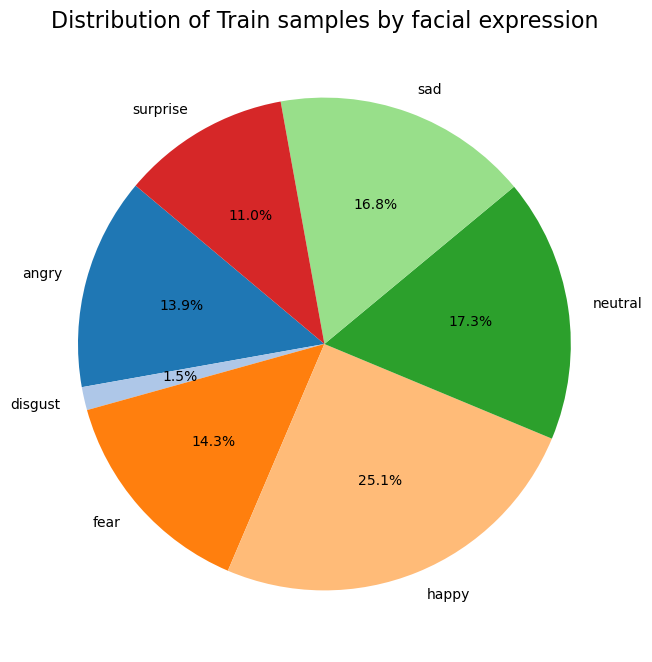

In [91]:
plt.figure(figsize=(8,8))
plt.pie(
    data_samples_summary['Train samples'], labels=data_samples_summary['Category'], autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors)
plt.title('Distribution of Train samples by facial expression', fontsize=16)
plt.show()

As we can see the dataset is imbalanced, so we need to take care of this while modeling.
- The most represented class is happy, and the less is disgust.

The size of the images

In [27]:
img = Image.open(os.path.join('train/happy', os.listdir('train/happy')[0]))
print('Shape of images:')
print(np.array(img).shape)

Shape of images:
(48, 48)


Let's see some images samples of each class.

In [4]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

def plot_one_image_per_class(base_path, classes, title='Sample Images per expression'):
    """
    Plot an image for each class
    """

    n_images = len(classes)
    w = int(np.ceil(np.sqrt(n_images)))
    h = int(np.ceil(n_images / w))

    plt.figure(figsize=(12, 8))

    for i, expression in enumerate(classes):
        class_path = os.path.join(base_path, expression)
        files = os.listdir(class_path)
        
        # Select a random image
        img_name = random.choice(files)
        img_path = os.path.join(class_path, img_name)

        # Here i resize the image to 128 x 128 to have more resolution
        img = Image.open(img_path).convert("RGB").resize((100, 100))

        plt.subplot(h, w, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(expression, fontsize=10)

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

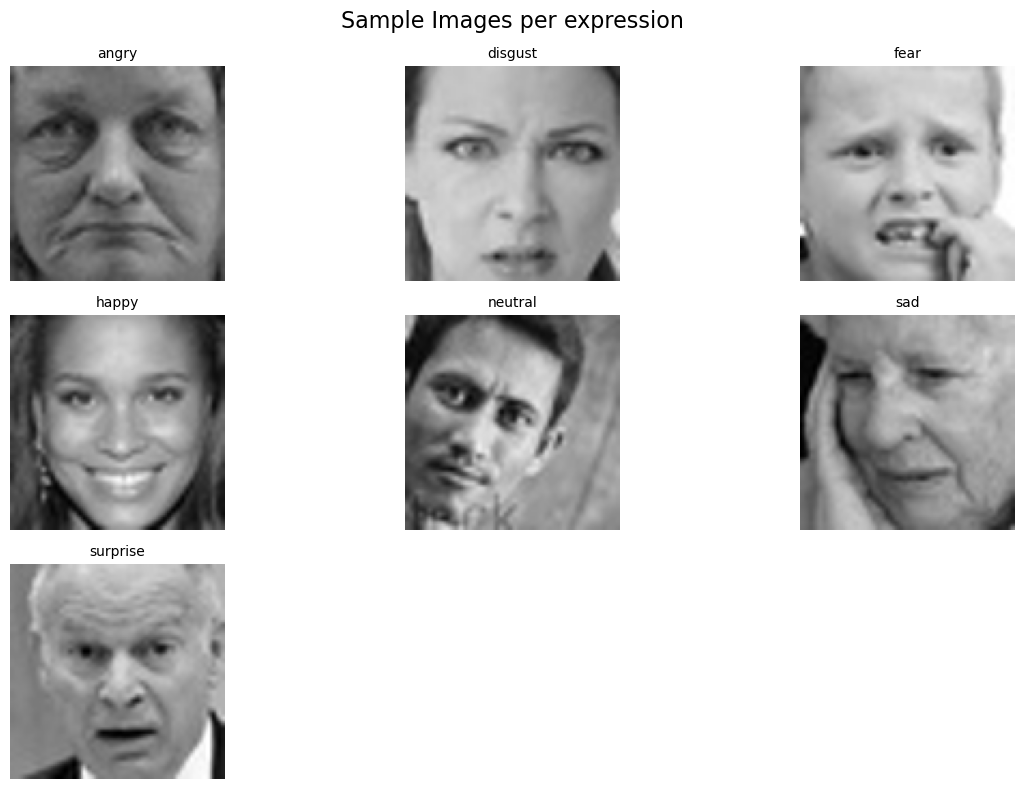

In [49]:
plot_one_image_per_class('train/', facial_expressions)

This problems it's interesting for me as the dataset is already labeled, but sometimes as humans we can malinterpret some emotions. Maybe, as some expressions are similar to others, the model can make mistakes in these too, so, after modeling I'll plot the confusion matrix and we'll analyze which are correlated to eachother.

##### Heatmaps
Now I'll plot a heatmap based on category. This will help to see how tipically a face expression is seen and not only using one sample.

In [88]:
def plot_average_heatmaps(base_path, classes):

    heatmaps = {}

    for expression in classes:
        cls_path = os.path.join(base_path, expression)
        n_files = len(os.listdir(cls_path))
        # Read the 90% of images
        n = int(n_files * 0.9)
        files = pd.Series(os.listdir(cls_path)).sample(n).values
        
        # Acumulate
        avg_img = np.zeros((48, 48))
            
        for f in files:
            img = Image.open(os.path.join(cls_path, f)).convert("L")
            img = img.resize((48, 48))  # Ensure consistent size
            avg_img += np.array(img, dtype=np.float32)

        avg_img /= n  # Average
        heatmaps[expression] = avg_img

    # Plot
    num = len(classes)
    cols = 4
    rows = int(np.ceil(num / cols))

    plt.figure(figsize=(12, 3 * rows))

    for i, expression in enumerate(classes):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(heatmaps[expression], cmap="viridis")
        plt.title(expression)
        plt.axis("off")

    plt.suptitle("Average Heatmaps per Class", fontsize=16)
    plt.tight_layout()
    plt.show()


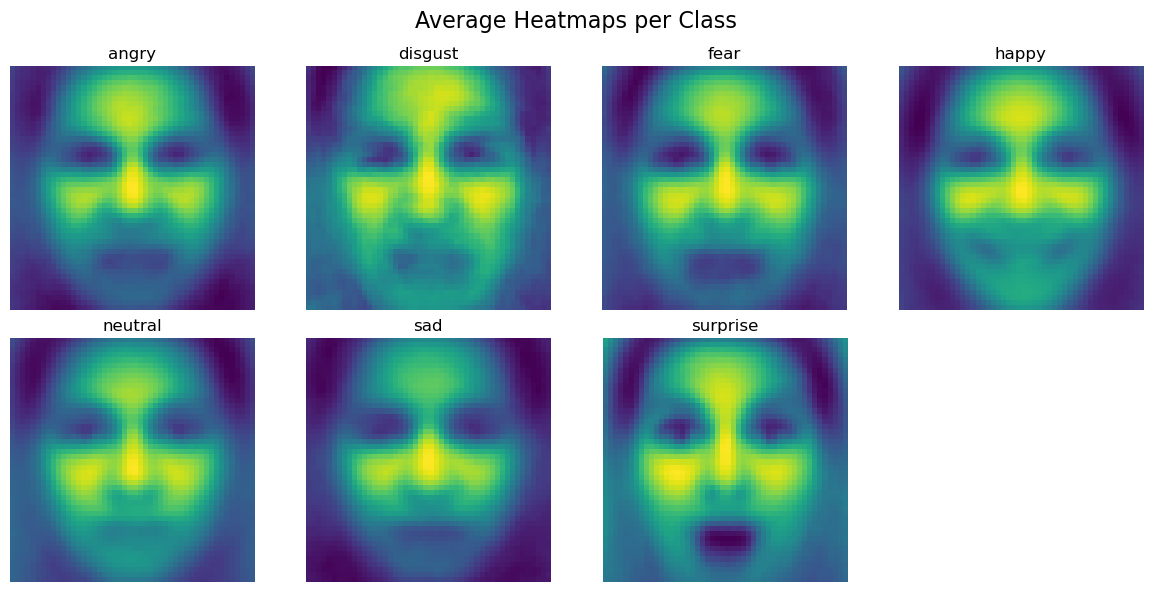

In [89]:
plot_average_heatmaps("train/", facial_expressions)

That looks great!. We can see the average image for each expression, and makes sense. For example:
- Happy faces usually have a big smile
- The surprised faces have open mouths
- For me the angry and fear are similar.

##### Intensity histogram per class
Finally I'll plot a histogram in order to see the average intensity in each pixel for facial expression.

In [5]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

def plot_intensity_histograms(base_path, classes, n=200):

    plt.figure(figsize=(12, 4))
    for i, expression in enumerate(classes):
        cls_path = os.path.join(base_path, expression)
        files = pd.Series(os.listdir(cls_path)).sample(n).values
        # Acumulate
        hist = np.zeros(256)
        for f in files:
            img = Image.open(os.path.join(cls_path, f)).convert("L")
            arr = np.array(img)
            hist += np.histogram(arr, bins=256, range=(0, 255))[0]
        hist /= n  # Average

        plt.plot(range(256), hist, label=expression)

    plt.title("Average Intensity Histograms per facial expression")
    plt.xlabel("Pixel Intensity (0-255)")
    plt.ylabel("Average Frequency")
    plt.legend()
    plt.show()


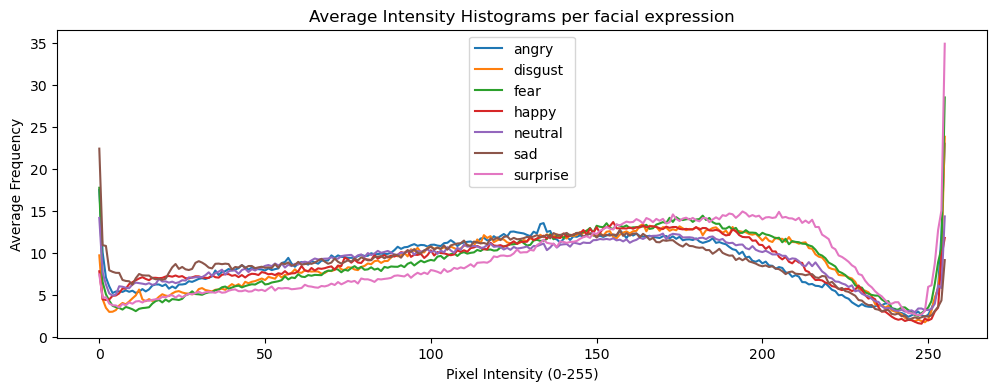

In [98]:
plot_intensity_histograms("train/", facial_expressions, n=300)


As you can see, the difference is not that clear between expresions, except the surprise, that has a different distribution.

But, the interesting part is that even when the difference is not clear, deep learning models can learn these representations.

Based on the EDA as the images are all the same size and only have one channel, there isn't much preprocessing that we can do except normalizing the images.

- However, in order to achieve better results I'll use data transformations techniques to improve performance.
- Tackle the imbalanced dataset.

# Data preparation
In this section I'll prepare the data with Pytorch.

In [6]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, WeightedRandomSampler

In [7]:
# Transformations for training
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48,48)), # Resize the image to ensure that all have 48x48 shape
    transforms.RandomHorizontalFlip(), # Performs horizonal flip in image randomly
    transforms.RandomRotation(10),  # Rotates the image randomly between (-10, 10) degrees
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2, 
        saturation=0.2, hue=0.05), # transform randomly changes the brightness, contrast, saturation, hue
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Transform the test data, but it doesn't apply the data augmentation techniques, only
# the basic ones.
test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48,48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

Load the data, ImageFolder asumes that each folder has one category.

In [8]:
train_dataset = datasets.ImageFolder(root='train/', transform=train_transforms)
test_dataset = datasets.ImageFolder(root='test/', transform=test_transforms)

In [9]:
print("Categories:", train_dataset.classes)

Categories: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


As we have a desbalanced class dataset, I'll use WeightedRandomSampler, which helps to ensure that during training overcomes the imbalance giving more weight to the minority class.

This works the following way:
- Allows you to sample elements from your dataset according to specified probabilities, rather than uniformly.

- This is especially useful for imbalanced datasets—like this one

- Instead of picking samples randomly with equal probability, you assign weights to each sample:
    - High weight → higher chance of being picked, higher weight for the subrepresented classes.

    - Low weight → lower chance of being picked

In [10]:
# Count samples per class
targets = [label for _, label in train_dataset]
class_counts = np.bincount(targets)
class_weights = 1. / class_counts

# Assign a wight for each class
sample_weights = [class_weights[t] for t in targets]

# Create sample
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)


Finally, create the DataLoaders, which converts the samples into batches for the training loop. Observe that here I pass the sampler but only to the train loader.

In [11]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


#### Visualization after tranformations

In [12]:
import torchvision

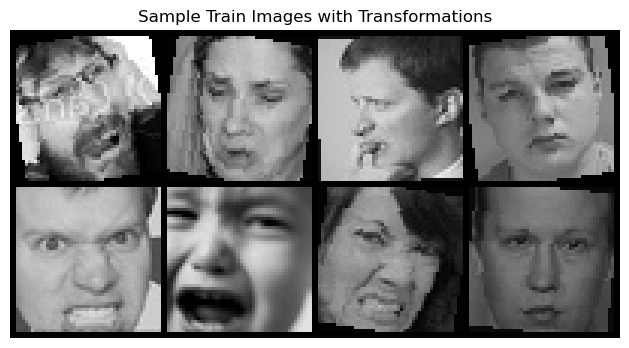

In [134]:
# Take a batch
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Take the first 8 images
images = images[:8]
labels = labels[:8]

# Denormalize the image
images = images * 0.5 + 0.5

# Make a grid and plot it
grid = torchvision.utils.make_grid(images, nrow=4)
plt.figure(figsize=(10,4))
plt.imshow(grid.permute(1,2,0).squeeze(), cmap='gray')  # permute para HWC
plt.title("Sample Train Images with Transformations")
plt.axis("off")
plt.show()


The transformations are not that excessive.

# Model architecture
I'll try two differents architectures.
- Simple: Only two blocks of convolutions and few filters.
- Advanced: Three blocks of convolutions and more filters in each of them and add batch normalization.

Then I'll see how it performs each of them and based on that, I'll do hyperparameter tuning in the best.

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [14]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(SimpleCNN, self).__init__()
        # Block 1
        # 1 input chanel as is gray images, and 32 filters
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)
        
        # Block 2
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.25)
        
        # Fully connected
        self.fc1 = nn.Linear(64 * 12 * 12, 128) # This is because after the first MaxPoool
        # the images went from 48x48 to 24x24, and after the second 12x12
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        # Block 1
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Block 2
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        return x


In [14]:
class CNNAdvanced(nn.Module):
    def __init__(self, num_classes=7):
        super(CNNAdvanced, self).__init__()
        
        # Block 1
        self.conv1_1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(64)
        self.drop1 = nn.Dropout(0.25)
        
        # Block 2
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.bn2 = nn.BatchNorm2d(128)
        self.drop2 = nn.Dropout(0.25)
        
        # Block 3
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2,2)
        self.bn3 = nn.BatchNorm2d(256)
        self.drop3 = nn.Dropout(0.25)
        
        # Fully connected
        self.fc1 = nn.Linear(256 * 6 * 6, 512)
        self.drop_fc1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        # Block 1
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.pool1(x)
        x = self.bn1(x)
        x = self.drop1(x)
        
        # Block 2
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.pool2(x)
        x = self.bn2(x)
        x = self.drop2(x)
        
        # Block 3
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = self.pool3(x)
        x = self.bn3(x)
        x = self.drop3(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected
        x = F.relu(self.fc1(x))
        x = self.drop_fc1(x)
        x = self.fc2(x)
        return x


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
simple_model = SimpleCNN().to(device)
print('Simple model architecture:')
print(simple_model)
print('*'*100)

Simple model architecture:
SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=7, bias=True)
)
****************************************************************************************************


In [16]:
advanced_model = CNNAdvanced().to(device)
print('Advanced model architecture:')
print(advanced_model)
print('*'*100)

Advanced model architecture:
CNNAdvanced(
  (conv1_1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop1): Dropout(p=0.25, inplace=False)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop2): Dropout(p=0.25, inplace=False)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=

#### Optimizer and Loss function
I'll use CrossEntropyLoss as is a multiclass classification problem and note that the output of each architecture are raw, as expected.

In [17]:
import torch.optim as optim

loss_function_simple_model = nn.CrossEntropyLoss()
# I'll use the Adam optimizer because is a great optimization method.
optimizer_simple_model = optim.Adam(simple_model.parameters(), lr=0.001)

loss_function_advanced_model = nn.CrossEntropyLoss()
# I'll use the Adam optimizer because is a great optimization method.
optimizer_advanced_model = optim.Adam(advanced_model.parameters(), lr=0.001)

Now, I define schedulers for adjusting the learning rate, which helps to change it during training.

In [18]:
scheduler_simple_model = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_simple_model, mode='max', factor=0.5, patience=2, min_lr=1e-5
)

scheduler_advanced_model = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_advanced_model, mode='max', factor=0.5, patience=2, min_lr=1e-5
)

# Training
In order to see the performance after each epoch I'll monitor the following metrics:

- Accuracy
- F1-Score

Here, I'll use only 15 epochs, in order to see which architecture performs better, and after that, I'll do hyperparameter tuning and with the winner I'll use more epochs.

In [51]:

from sklearn.metrics import f1_score

def training_model(num_epochs, optimizer, model, loss_function, scheduler, model_save_path, print_all_epochs=True):
    # This is the value to store the best validation F1 score and save the best model
    best_val_f1 = -1.0
    # Iterate all the data in each epoch
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        # In this part, it iterates over each batch
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Set gradients to zero, because Pytorch acumulates the previous ones.
            optimizer.zero_grad()
            outputs = model(images)
            # calculate the loss
            loss = loss_function(outputs, labels)
            # Calculate the gradients respect to the loss
            loss.backward()
            # Finally update the parameters based on the gradients calculated with loss.backward()
            optimizer.step()

            # Calculate the loss
            running_loss += loss.item() * images.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        
        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        # here I'll save the labels and prediction for each batch in the validation set
        all_labels = []
        all_preds = []

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = loss_function(outputs, labels)
                val_loss += loss.item() * images.size(0)
                
                probs = F.softmax(outputs, dim=1) # for multi class
                preds = torch.argmax(probs, dim=1) # Select the predicted class
                correct += (preds == labels).sum().item()

                all_labels.append(labels.cpu())
                all_preds.append(preds.cpu())

        val_loss = val_loss / len(test_loader.dataset)
        val_acc = correct / len(test_loader.dataset)

        # Concat para todas las batches
        all_labels = torch.cat(all_labels).numpy()
        all_preds = torch.cat(all_preds).numpy()

        val_acc = np.mean(all_preds == all_labels)
        val_f1 = f1_score(all_labels, all_preds, average='macro')
        if print_all_epochs:
            print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")
            print(f"Test Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, F1-score: {val_f1:.4f}")
        else:
            if epoch % 10 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")
                print(f"Test Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, F1-score: {val_f1:.4f}")

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            # Save the best model parameter
            torch.save(model.state_dict(), model_save_path)
            print(f"Best model saved with F1-score: {best_val_f1:.4f}")

        # Update the learning rate with the scheduler
        scheduler.step(val_f1) # Based on F1 Score, maximize it

Let's train this simple model.

In [23]:
training_model(
    num_epochs=15, optimizer=optimizer_simple_model,
    model=simple_model, loss_function=loss_function_simple_model,
    scheduler=scheduler_simple_model,
    model_save_path='models/face_rec_best_simple_cnn_model.pth')

Epoch 1/15, Training Loss: 1.8295
Test Loss: 1.6880, Accuracy: 0.3491, F1-score: 0.2878
Best model saved with F1-score: 0.2878
Epoch 2/15, Training Loss: 1.6508
Test Loss: 1.4929, Accuracy: 0.4267, F1-score: 0.3647
Best model saved with F1-score: 0.3647
Epoch 3/15, Training Loss: 1.5208
Test Loss: 1.3925, Accuracy: 0.4618, F1-score: 0.4006
Best model saved with F1-score: 0.4006
Epoch 4/15, Training Loss: 1.4659
Test Loss: 1.3845, Accuracy: 0.4634, F1-score: 0.3988
Epoch 5/15, Training Loss: 1.4224
Test Loss: 1.3421, Accuracy: 0.4858, F1-score: 0.4429
Best model saved with F1-score: 0.4429
Epoch 6/15, Training Loss: 1.3807
Test Loss: 1.3402, Accuracy: 0.4880, F1-score: 0.4343
Epoch 7/15, Training Loss: 1.3557
Test Loss: 1.2585, Accuracy: 0.5167, F1-score: 0.4650
Best model saved with F1-score: 0.4650
Epoch 8/15, Training Loss: 1.3448
Test Loss: 1.2361, Accuracy: 0.5230, F1-score: 0.4774
Best model saved with F1-score: 0.4774
Epoch 9/15, Training Loss: 1.3189
Test Loss: 1.2403, Accuracy:

In [21]:
training_model(
    num_epochs=15, optimizer=optimizer_advanced_model,
    model=advanced_model, loss_function=loss_function_advanced_model,
    scheduler=scheduler_advanced_model,
    model_save_path='models/face_rec_best_advanced_cnn_model.pth')

Epoch 1/15, Training Loss: 1.7614
Test Loss: 1.4777, Accuracy: 0.4407, F1-score: 0.3815
Best model saved with F1-score: 0.3815
Epoch 2/15, Training Loss: 1.4671
Test Loss: 1.3372, Accuracy: 0.4890, F1-score: 0.4357
Best model saved with F1-score: 0.4357
Epoch 3/15, Training Loss: 1.3356
Test Loss: 1.2428, Accuracy: 0.5263, F1-score: 0.4779
Best model saved with F1-score: 0.4779
Epoch 4/15, Training Loss: 1.2550
Test Loss: 1.2101, Accuracy: 0.5461, F1-score: 0.4891
Best model saved with F1-score: 0.4891
Epoch 5/15, Training Loss: 1.1758
Test Loss: 1.1362, Accuracy: 0.5706, F1-score: 0.5273
Best model saved with F1-score: 0.5273
Epoch 6/15, Training Loss: 1.1301
Test Loss: 1.1396, Accuracy: 0.5627, F1-score: 0.5269
Epoch 7/15, Training Loss: 1.0977
Test Loss: 1.1071, Accuracy: 0.5763, F1-score: 0.5465
Best model saved with F1-score: 0.5465
Epoch 8/15, Training Loss: 1.0733
Test Loss: 1.1040, Accuracy: 0.5832, F1-score: 0.5513
Best model saved with F1-score: 0.5513
Epoch 9/15, Training Lo

In [60]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [66]:
def plot_confusion_matrix(model, data_loader):
    '''
    Model: The model to make predictions
    data_loader: The data batches, train or test
    '''
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            # This is necessesary because the model outputs the raw after 
            # the conected layer, no the probability
            probs = F.softmax(outputs, dim=1) # for multi class
            preds = torch.argmax(probs, dim=1) # Select the predicted class
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())
    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    test_acc = np.mean(all_preds == all_labels)
    test_f1 = f1_score(all_labels, all_preds, average='macro')

    classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

    conf_matrix = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes)
    plt.figure(figsize=(8, 6))
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title(f"Confusion Matrix Test: F1-Score {np.round(100*test_f1):.1f} | Accuracy: {100*test_acc:.1f}")
    plt.show()

##### Confusion matrix simple model

<Figure size 800x600 with 0 Axes>

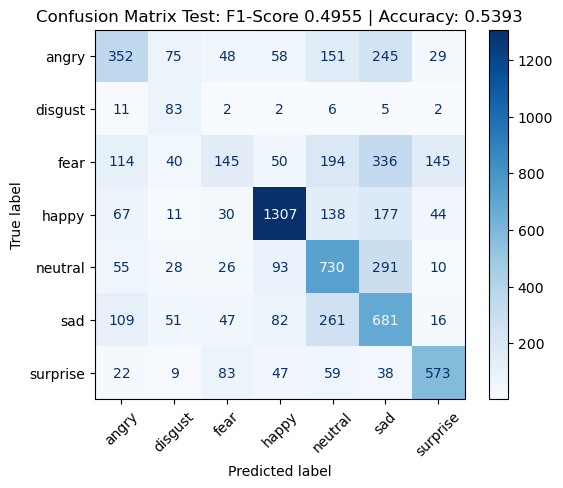

In [28]:
plot_confusion_matrix(simple_model, test_loader)

##### Confusion matrix advanced model

<Figure size 800x600 with 0 Axes>

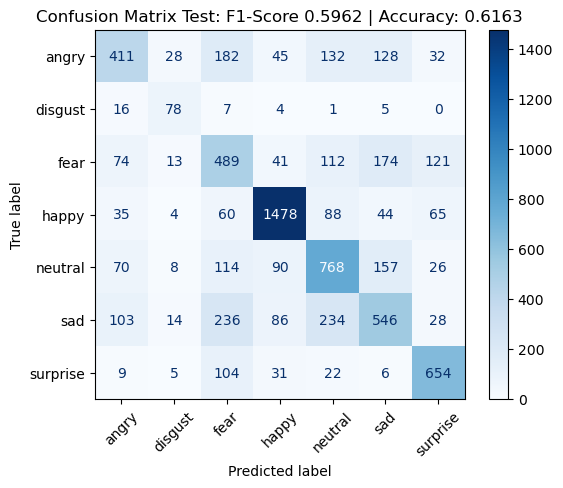

In [29]:
plot_confusion_matrix(advanced_model, test_loader)

As we can see the advanced model is clearly better tha the simple one. So, I'll choose it for hyperparameter tuning.
Also analyzing the confussion matrix I noted the following:
- Fear is confused with sadness and other emotions.
- Sad and neutral are confused with each other
- Happy and disgust are the one with less errors. This is because we saw, happy is very different from the rest.

# Hyperparameter tuning
Here, I'll use the advanced model architecture and tune the following hyperparameters:

- Dropout propotion
- Learning rate
- Depth in each convolution layer
- Units in the fully conected layer, the last one to prediction


I'll be using optuna is an open-source Python library designed for automatic hyperparameter optimization. You can learn more about Optuna here: https://optuna.readthedocs.io/en/stable/

In [26]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score

In [32]:
def objective(trial):
    # Hyperparameters
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    dropout = trial.suggest_float('dropout', 0.2, 0.5)
    fc_size = trial.suggest_int('fc_size', 256, 512)
    
    num_filters1 = trial.suggest_int('num_filters1', 32, 64)
    num_filters2 = trial.suggest_int('num_filters2', 64, 128)
    num_filters3 = trial.suggest_int('num_filters3', 128, 256)
    
    # In this architecture I'll not include batch normalization for faster hyperparameter tuning
    # But, once the best parameters are found I'll use the batch normalization again
    class TunedCNN(nn.Module):
        def __init__(self, num_classes=7):
            super().__init__()
            # Block 1
            self.conv1_1 = nn.Conv2d(1, num_filters1, 3, padding=1)
            self.conv1_2 = nn.Conv2d(num_filters1, num_filters1, 3, padding=1)
            self.pool1 = nn.MaxPool2d(2,2)
            self.drop1 = nn.Dropout(dropout)
            
            # Block 2
            self.conv2_1 = nn.Conv2d(num_filters1, num_filters2, 3, padding=1)
            self.conv2_2 = nn.Conv2d(num_filters2, num_filters2, 3, padding=1)
            self.pool2 = nn.MaxPool2d(2,2)
            self.drop2 = nn.Dropout(dropout)
            
            # Block 3
            self.conv3_1 = nn.Conv2d(num_filters2, num_filters3, 3, padding=1)
            self.conv3_2 = nn.Conv2d(num_filters3, num_filters3, 3, padding=1)
            self.pool3 = nn.MaxPool2d(2,2)
            self.drop3 = nn.Dropout(dropout)
            
            # Fully connected
            self.fc1 = nn.Linear(num_filters3*6*6, fc_size)
            self.drop_fc = nn.Dropout(dropout)
            self.fc2 = nn.Linear(fc_size, num_classes)
            
        def forward(self, x):
            x = F.relu(self.conv1_1(x))
            x = F.relu(self.conv1_2(x))
            x = self.pool1(x)
            x = self.drop1(x)
            
            x = F.relu(self.conv2_1(x))
            x = F.relu(self.conv2_2(x))
            x = self.pool2(x)
            x = self.drop2(x)
            
            x = F.relu(self.conv3_1(x))
            x = F.relu(self.conv3_2(x))
            x = self.pool3(x)
            x = self.drop3(x)
            
            x = x.view(x.size(0), -1)
            x = F.relu(self.fc1(x))
            x = self.drop_fc(x)
            x = self.fc2(x)
            return x
    
    # Instantiate the model
    model = TunedCNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    # Training with only one epoch
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    # Test performance
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1) # for multi class
            preds = torch.argmax(probs, dim=1) # Select the predicted class
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())
            
    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    val_f1 = f1_score(all_labels, all_preds, average='macro')
    
    # Return the metric for optimize
    return val_f1


In [33]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2025-11-20 22:26:08,268] A new study created in memory with name: no-name-656f62e8-2485-4fa2-9d2f-a1b1663182fd
[I 2025-11-20 22:26:24,669] Trial 0 finished with value: 0.27432521206289795 and parameters: {'lr': 0.000633868395766216, 'dropout': 0.35170870515141317, 'fc_size': 286, 'num_filters1': 54, 'num_filters2': 86, 'num_filters3': 216}. Best is trial 0 with value: 0.27432521206289795.
[I 2025-11-20 22:26:40,805] Trial 1 finished with value: 0.2694099518468372 and parameters: {'lr': 0.0009442480374408908, 'dropout': 0.22375895350962646, 'fc_size': 313, 'num_filters1': 43, 'num_filters2': 72, 'num_filters3': 193}. Best is trial 0 with value: 0.27432521206289795.
[I 2025-11-20 22:26:56,941] Trial 2 finished with value: 0.21523843649016872 and parameters: {'lr': 0.0005140275774525415, 'dropout': 0.47163084653251014, 'fc_size': 322, 'num_filters1': 52, 'num_filters2': 90, 'num_filters3': 224}. Best is trial 0 with value: 0.27432521206289795.
[I 2025-11-20 22:27:13,252] Trial 3 finish

As you can see the F1 - scores are not high, that's because I'm using only one epoch.

In [34]:

print("Best trial:")
trial = study.best_trial
print(trial.params)

Best trial:
{'lr': 0.00028784359284947744, 'dropout': 0.34217105642199547, 'fc_size': 385, 'num_filters1': 34, 'num_filters2': 124, 'num_filters3': 198}


Now that we found the best hyperparameters, let's implement the advanced CNN architecture and train it with more epochs.

In [16]:
class CNNAdvanced_tunned(nn.Module):
    def __init__(self, num_classes=7):
        super(CNNAdvanced_tunned, self).__init__()
        
        # Block 1
        self.conv1_1 = nn.Conv2d(1, 34, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(34, 34, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(34)
        self.drop1 = nn.Dropout(0.34217105642199547)
        
        # Block 2
        self.conv2_1 = nn.Conv2d(34, 124, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(124, 124, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.bn2 = nn.BatchNorm2d(124)
        self.drop2 = nn.Dropout(0.34217105642199547)
        
        # Block 3
        self.conv3_1 = nn.Conv2d(124, 198, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(198, 198, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2,2)
        self.bn3 = nn.BatchNorm2d(198)
        self.drop3 = nn.Dropout(0.34217105642199547)
        
        # Fully connected
        self.fc1 = nn.Linear(198 * 6 * 6, 385)
        self.drop_fc1 = nn.Dropout(0.34217105642199547)
        self.fc2 = nn.Linear(385, num_classes)
        
    def forward(self, x, extract_latent=False):
        # Block 1
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.pool1(x)
        x = self.bn1(x)
        x = self.drop1(x)
        
        # Block 2
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.pool2(x)
        x = self.bn2(x)
        x = self.drop2(x)
        
        # Block 3
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = self.pool3(x)
        x = self.bn3(x)
        x = self.drop3(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected
        x = F.relu(self.fc1(x))
        # I add this part for later visualizing the results once the model is trained
        if extract_latent:
            return x
        x = self.drop_fc1(x)
        x = self.fc2(x)

        
        return x

Then, I'll define the tunned model with the optimized architecture, use the same loss function and use a scheduer too.

In [19]:
tunned_model = CNNAdvanced_tunned().to(device)

In [53]:
loss_function_tunned_model = nn.CrossEntropyLoss()

In [54]:
optimizer_tunned_model = optim.Adam(tunned_model.parameters(), lr=0.00028784359284947744)

In [55]:
scheduler_tunned_model = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_tunned_model, mode='max', factor=0.5, patience=2, min_lr=1e-5
)

In [56]:
training_model(
    num_epochs=100, optimizer=optimizer_tunned_model,
    model=tunned_model, loss_function=loss_function_tunned_model,
    scheduler=scheduler_tunned_model,
    model_save_path='models/face_rec_best_tunned_cnn_model.pth',
    print_all_epochs=False)

Epoch 1/100, Training Loss: 1.6911
Test Loss: 1.4780, Accuracy: 0.4388, F1-score: 0.3764
Best model saved with F1-score: 0.3764
Best model saved with F1-score: 0.4282
Best model saved with F1-score: 0.4830
Best model saved with F1-score: 0.5074
Best model saved with F1-score: 0.5348
Best model saved with F1-score: 0.5700
Best model saved with F1-score: 0.5905
Epoch 11/100, Training Loss: 0.8741
Test Loss: 1.0433, Accuracy: 0.6257, F1-score: 0.6025
Best model saved with F1-score: 0.6025
Best model saved with F1-score: 0.6091
Best model saved with F1-score: 0.6115
Best model saved with F1-score: 0.6171
Best model saved with F1-score: 0.6403
Epoch 21/100, Training Loss: 0.6754
Test Loss: 1.0137, Accuracy: 0.6502, F1-score: 0.6405
Best model saved with F1-score: 0.6405
Best model saved with F1-score: 0.6486
Best model saved with F1-score: 0.6492
Best model saved with F1-score: 0.6542
Epoch 31/100, Training Loss: 0.5574
Test Loss: 1.0374, Accuracy: 0.6649, F1-score: 0.6571
Best model saved 

##### Confusion matrix tunned model

<Figure size 800x600 with 0 Axes>

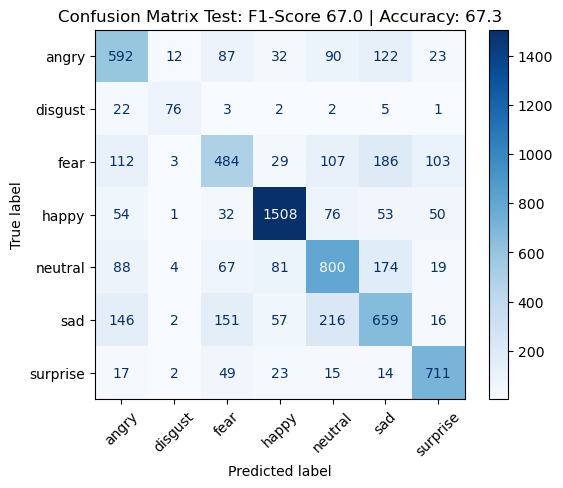

In [67]:
plot_confusion_matrix(tunned_model, test_loader)

We improved the model a lot by doing hyperparameter tuning and using more epochs. Now I reached an accuracy of 67.3

##### Classification report

In [87]:
all_labels = []
all_preds = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = tunned_model(images)
        # This is necessesary because the model outputs the raw after 
        # the conected layer, no the probability
        probs = F.softmax(outputs, dim=1) # for multi class
        preds = torch.argmax(probs, dim=1) # Select the predicted class
        all_labels.append(labels.cpu())
        all_preds.append(preds.cpu())
all_labels = torch.cat(all_labels).numpy()
all_preds = torch.cat(all_preds).numpy()

classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [88]:
from sklearn.metrics import classification_report
print(classification_report(all_labels, all_preds, target_names=classes))

              precision    recall  f1-score   support

       angry       0.57      0.62      0.60       958
     disgust       0.76      0.68      0.72       111
        fear       0.55      0.47      0.51      1024
       happy       0.87      0.85      0.86      1774
     neutral       0.61      0.65      0.63      1233
         sad       0.54      0.53      0.54      1247
    surprise       0.77      0.86      0.81       831

    accuracy                           0.67      7178
   macro avg       0.67      0.67      0.67      7178
weighted avg       0.67      0.67      0.67      7178



#### Visualize some random predictions

In [70]:
import random

In [27]:
classes = ['angry','disgust','fear','happy','neutral','sad','surprise']

def show_random_predictions(model, n_images=6):
    model.eval()
    images_shown = 0

    plt.figure(figsize=(12, 6))

    # Convert dataloader into batches list
    data_iter = iter(test_loader)
    images_list = []

    # Add images from batches
    for _ in range(10):
        try:
            images, labels = next(data_iter)
            for img, lab in zip(images, labels):
                images_list.append((img, lab))
        except:
            break

    # Select n random fces images
    samples = random.sample(images_list, n_images)

    for i, (img, label) in enumerate(samples):
        img_input = img.unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(img_input)
            preds = torch.softmax(outputs, dim=1)
            pred_class = torch.argmax(preds, dim=1).item()
            confidence = preds[0][pred_class].item()

        color = "green" if pred_class == label.item() else "red"
        # Convert to tensor
        img_np = img.squeeze().cpu().numpy()

        plt.subplot(2, n_images // 2, i + 1)
        plt.imshow(img_np, cmap="gray")
        plt.axis("off")
        plt.title(
            f"True: {classes[label]}\nPred: {classes[pred_class]}\nConf: {confidence:.2f}",
            fontsize=9,
            color=color
        )

    plt.tight_layout()
    plt.show()


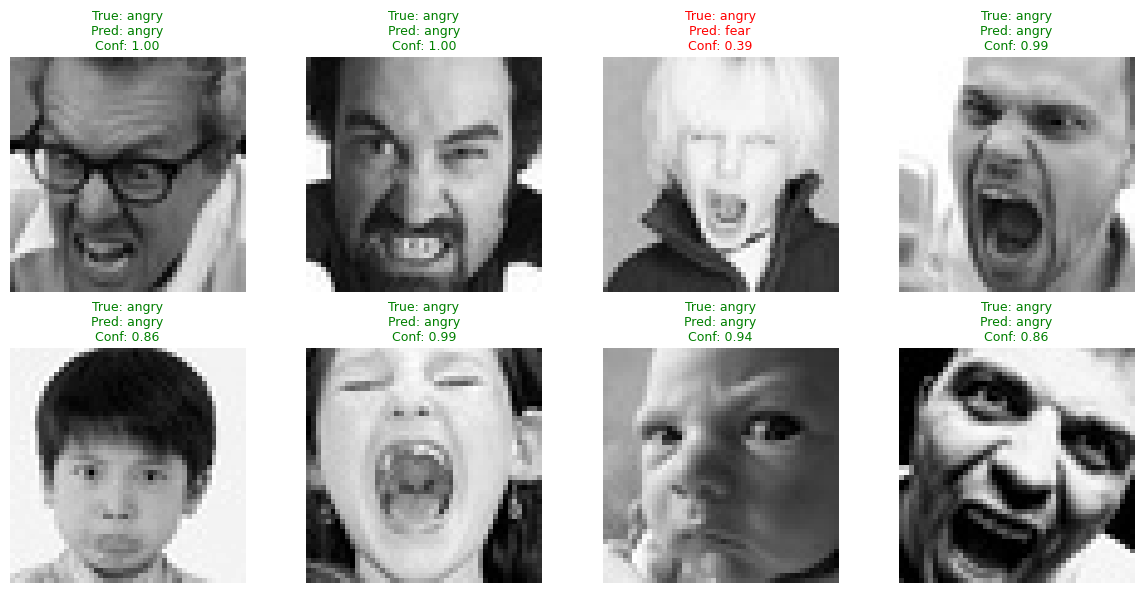

In [82]:
show_random_predictions(tunned_model, n_images=8)

#### Visalize using PCA
Now, I'll visualize a sample of observations for each emotion using PCA from the last layer before the output.

In [21]:
tunned_model.eval()

embeddings = []
labels_list = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        # here we set extract_latent = True
        latent = tunned_model(images, extract_latent=True)
        latent = latent.view(latent.size(0), -1)
        embeddings.append(latent.cpu())
        labels_list.append(labels)

embeddings = torch.cat(embeddings).numpy()
labels_list = torch.cat(labels_list).numpy()


In [32]:
# Create a dataframe for the embeddings to sample based on the class
embeddings_df = pd.DataFrame(embeddings)

In [34]:
embeddings_df['class'] = labels_list

In [51]:
# Sample to have 100 embeddings per expression
sampled_df_frac = embeddings_df.groupby('class').apply(lambda x: x.sample(100, random_state=102)).reset_index(drop=True)


/tmp/ipykernel_4694/3669943773.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df_frac = embeddings_df.groupby('class').apply(lambda x: x.sample(100, random_state=102)).reset_index(drop=True)


In [52]:
from sklearn.decomposition import PCA

In [48]:
classes = ['angry','disgust','fear','happy','neutral','sad','surprise']

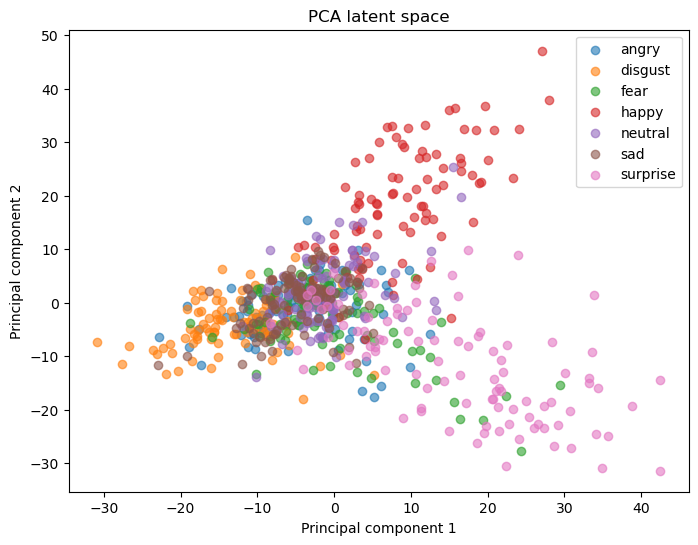

In [56]:
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(sampled_df_frac.drop(columns='class'))

plt.figure(figsize=(8,6))
for expression in range(7):
    idx = sampled_df_frac['class'] == expression
    plt.scatter(emb_2d[idx, 0], emb_2d[idx, 1], label=classes[expression], alpha=0.6)

plt.legend()
plt.title("PCA latent space")
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.show()


It makes sense with the confussion matrix and classification report.
- The happy, suprise and disgust are the expressions that are most separated from the others
- The others are closer to eachother, which makes it more difficult to classify as they are more similar.

# Conclusions

- The advanced architecture is better suited for this problem, as it's deeper it captures more information.
- The model performs strongly on this expressions:
    - Happy: This is the most easily recognized class, showing high precision and recall
    - Surprise and disgust: These classese are also well-classified.
- The model struggles with negative emotions like:
    - Fear: This is the weakest class. It has very low recall and precision, with instances often misclassified as angry and sad.
    - Sad: Their instances are often misclassified as neutral fear and angry.
- Even though the sad and fear classes have more observations, it have a worse performance compared to disgust:
    - The WeightedRandomSampler helped to overcome this issue of imbalanced dataset.




# Next steps
- Incorporate more data augmentation specifically targeting rare classes, use more sophisticated methods.
- Try a deeper architecture, as we saw that a deeper performed better.
- Tune how many convolutional layers use.
- Use more epochs.
- Experiment with ensemble models.